In [ ]:
# Setup
from generateDataset import generateDataset
generateDataset()

🎯 Categorías encontradas: ['anartia_amathea', 'heliconius_doris', 'melanis_electron']

🐞 Categoría: anartia_amathea
📄 71 archivos copiados para entrenamiento
📄 20 archivos copiados para testing
📄 10 archivos copiados para validación

🐞 Categoría: heliconius_doris
📄 52 archivos copiados para entrenamiento
📄 15 archivos copiados para testing
📄 8 archivos copiados para validación

🐞 Categoría: melanis_electron
📄 52 archivos copiados para entrenamiento
📄 15 archivos copiados para testing
📄 8 archivos copiados para validación



In [11]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

imageGenerator = ImageDataGenerator(rotation_range=15, width_shift_range=0.4, height_shift_range=0.1, brightness_range=(0,0.2))

def trainModel():
    #Generate more images
    trainGenerator = imageGenerator.flow_from_directory("./dataset/train", target_size=(320,320), batch_size=32)
    testGenerator = imageGenerator.flow_from_directory("./dataset/test", target_size=(320,320), batch_size=32)
    
    #Build model
    baseModel = MobileNetV3Small(weights="imagenet", include_top=False)
    x = baseModel.output
    x = GlobalAveragePooling2D()(x) #1
    x = Dense(512, activation="relu")(x) #2
    x = Dense(256, activation="relu")(x) #3
    x = Dense(128, activation="relu")(x) #4

    predictionLayer = Dense(len(categories), activation="softmax")(x) #5

    model = Model(inputs=baseModel.input, outputs=predictionLayer)

    #Congelar todas las capas del modelo menos las 5 añadidas por nosotros
    #Deja fijos los pesos de MobileNetV3 pero permite modificar los pesos de las capas que creamos
    for layer in model.layers[:-5]:
        layer.trainable = False

    #Compilar modelo
    optimizer = Adam(learning_rate = 0.001)
    model.compile(
            loss="categorical_crossentropy", 
            optimizer=optimizer, 
            metrics=['accuracy']
        )

    #Entrenar modelo
    modelTrainData = model.fit(trainGenerator, validation_data=testGenerator, epochs=10)

    #Guardar modelo
    saveModelPath = "./dataset/ModelV3.keras"
    model.save(saveModelPath)

    plt.figure()
    plt.subplot(211)
    plt.plot(modelTrainData.history['accuracy'])
    plt.subplot(212)
    plt.plot(modelTrainData.history['loss'])
    
    return model

def loadModel():
    return tf.keras.models.load_model('./dataset/ModelV3.keras')

In [12]:
# Load model instead of train
#trainModel()
model = loadModel()

Found 133 images belonging to 3 classes.


/opt/miniconda3/envs/analitica/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 497ms/step

Classification Report:
                  precision    recall  f1-score   support

 anartia_amathea       0.84      1.00      0.91        53
heliconius_doris       1.00      0.80      0.89        46
melanis_electron       0.91      0.88      0.90        34

        accuracy                           0.90       133
       macro avg       0.92      0.90      0.90       133
    weighted avg       0.91      0.90      0.90       133



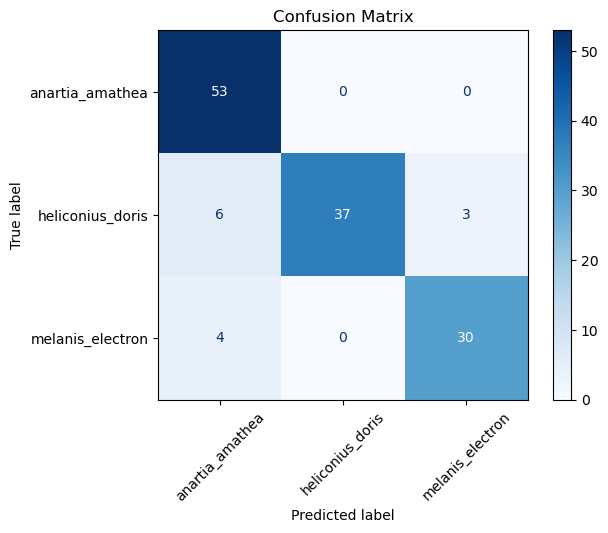

In [13]:

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
validateGenerator = imageGenerator.flow_from_directory("./dataset/validate", target_size=(320,320), batch_size=32, shuffle=False)
predictions = model.predict(validateGenerator)

y_pred = np.argmax(predictions, axis=1)
y_true = validateGenerator.classes

# Class labels
class_labels = list(validateGenerator.class_indices.keys())

# Accuracy & F1 metrics
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels).plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

Macro-Averaged AUC: 0.9906142016240614


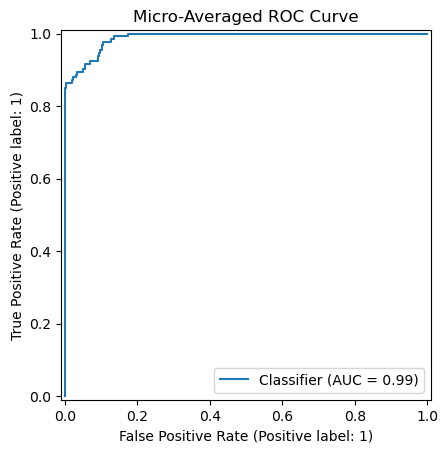

In [14]:
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import label_binarize

y_true_bin = label_binarize(y_true, classes=range(len(class_labels)))
# Macro-averaged AUC
macro_auc = roc_auc_score(y_true_bin, predictions, average="macro", multi_class="ovr")
print("Macro-Averaged AUC:", macro_auc)

# Micro-averaged ROC Curve
RocCurveDisplay.from_predictions(y_true_bin.ravel(), predictions.ravel())
plt.title("Micro-Averaged ROC Curve")
plt.show()

In [ ]:
import cv2
from modelGradCam import computeGradcam, overlayHeatmap

img_path="./dataset/validate/anartia_amathea/5416275.jpg"

heatmap = computeGradcam(model, img_path, class_index=0)
output_img = overlayHeatmap(img_path, heatmap)

cv2.imwrite("heatmap.jpg", output_img)

True